In [ ]:
!pip install pysndfx
!apt install sox

  Created wheel for pysndfx: filename=pysndfx-0.3.6-cp36-none-any.whl size=6555 sha256=7adcdf4a55660cb2ed09d1842964c1f88aaff98dc6d3023e44e96e6ebd9a0f6c
  Stored in directory: /root/.cache/pip/wheels/cd/76/ec/4e83f591f99a9cd17f7487fd75d83027aa65affe82dc2aa9df
Successfully built pysndfx
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 35 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB o

In [ ]:
!git clone https://github.com/Xirzag/TFM-Audio-Dereverberation.git

Cloning into 'Demucs-Git'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 6), reused 20 (delta 2), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [ ]:
%cd Demucs-Git/

/content/Demucs-Git


In [ ]:
from google.colab import drive
drive.mount('/content/Demucs-Git/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Demucs-Git/Drive


In [ ]:
import sys

import numpy as np
import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

from utils import apply_model, average_metric, center_trim 
from model import Demucs
import torch as th

device = "cpu"
if th.cuda.is_available():
    device = "cuda"
    
print(device)

cuda


In [ ]:
th.cuda.empty_cache()
model = Demucs(
             audio_channels=1,
             channels=64,
             sources=1,
             use_gru= True
        ).to(device)

In [ ]:
if True:
    model.load_state_dict(th.load('Drive/My Drive/Reverb Dataset/Cache/model23.pth'))

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch total trainable params', pytorch_total_params)

print(model)


pytorch total trainable params 223715969
Demucs(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 64, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
  

In [ ]:
# from audio import AudioFile 
from IPython.display import clear_output
from pysndfx import AudioEffectsChain
from librosa import load
from librosa import get_duration
from numpy import random

global_index_history = []

class AugmentedReverbs:
    def __init__(self, paths=None, duration=None, iters=None, samplerate=None, reverb_params={}, 
                 verbose_load=True, reverb_params2={}):
        
        self.index_history = []
        if paths is None:
            return

        self.paths = paths
        self.iters = iters
        self.duration = duration
        self.samplerate = samplerate
        self.sounds = []
        self._read_all(verbose_load)
        self.reverb_params = reverb_params
        self.reverb_params2 = reverb_params2
        self.augmentation = True

    def _read_all(self, verbose_load):
        length = len(self.paths)
        for i, f in enumerate(self.paths):
            sound, sr = load(f, sr=self.samplerate)
            self.sounds.append(sound)
            if verbose_load:
                print(f'{i}/{length} {f}')
                clear_output(wait=True)

    def __len__(self):
        return len(self.paths)

    def copy(other):
        a = AugmentedReverbs()
        a.paths = other.paths
        a.iters = other.iters
        a.duration = other.duration
        a.samplerate = other.samplerate
        a.sounds = other.sounds
        a.reverb_params = other.reverb_params
        a.reverb_params2 = other.reverb_params2
        a.augmentation = other.augmentation

        return a

    def set_duration(self, duration):
        self.duration = duration

    def set_reverb_param(self, params):
        self.reverb_params = params

    def set_reverb_params(self, params, params2):
        self.reverb_params = params
        self.reverb_params2 = params2

    def set_sounds(self, sounds):
        self.sounds = sounds

    def set_iters(self, iters):
        self.iters = iters

    def get_sounds(self):
        return self.sounds

    def track_path(self, index):
        return self.paths[index]

    def _load(self, index, offset=0, duration=None):
        if duration != None:
             duration /= self.samplerate

        sound, sr = load(self.paths[index], sr=self.samplerate,
                         offset=offset / self.samplerate,
                         duration=duration)
        
        if sr != None and sr != self.samplerate:
            raise ValueError(f'{self.paths[index]} samplerate is {sr} instead of {self.samplerate}')

        return sound

    def _get_length(self, index):
        length = get_duration(filename=self.paths[index])
        return int(np.floor(length * self.samplerate))

    def _mix_sounds(self, sound_input, index):
        length = len(self.sounds[index])
        
        if length < self.duration:
            to_add = self.sounds[index]
            start = random.randint(0, self.duration - length)
            end = self.duration - start - length
            to_add = np.pad(to_add, (start, end), constant_values=0)
            sound_input += to_add
        else:
            start = random.randint(0, max(1, length - self.duration))
            to_add = self.sounds[index][start : start + self.duration]
            sound_input += to_add

        return sound_input

    def apply_reverb(self, sound):
        if self.reverb_params2 is not None:
            reverb_params = {}
            for k in self.reverb_params:
                if k in self.reverb_params2:
                    reverb_params[k] = random.uniform(self.reverb_params[k],
                                                      self.reverb_params2[k])
                else:
                    reverb_params[k] = self.reverb_params[k]

        else:
            reverb_params = self.reverb_params

        fx = (
            AudioEffectsChain()
            .reverb(**reverb_params)
        )
        if self.augmentation:
            return fx(sound)[:self.duration]
        else:
            return fx(sound)[:len(sound)]

    def use_augmentation(self, use_it=True):
        self.augmentation = use_it

    def __getitem__(self, index):
        self.index_history.append(index)
        global_index_history.append(index)

        if self.augmentation:
            sound_input = np.zeros(self.duration)
            index_to_add = index

            for iter in range(self.iters):          
                sound_input = self._mix_sounds(sound_input, index_to_add)
                index_to_add = random.randint(0, len(self.paths) - 1)
                
        else:
            sound_input = self.sounds[index]

        sound_output = self.apply_reverb(sound_input)

        mean = np.mean(sound_input)
        std = np.std(sound_input)

        sound_input = (sound_input - mean) / std
        sound_output = (sound_output - mean) / std

        streams = np.array([sound_input, sound_output]).astype('float32')

        streams = np.expand_dims(streams, 0)

        return th.from_numpy(streams)

In [ ]:
%%time
import os.path
import glob

samplerate = 44100
args_samples = 44100 * 10
reverbs_cache_path = 'Drive/My Drive/Reverb Dataset/Cache/reverb_datasets.pickle'

if os.path.isfile(reverbs_cache_path):
    dataset_train, dataset_val, dataset_test = th.load(reverbs_cache_path)
else:

    files = glob.glob('Drive/My Drive/Reverb Dataset/d*/input/*.wav')
    number_of_files = len(files)

    np.random.shuffle(files)

    data_split = [.8, .05, .15]
    data_sizes = [int(d * number_of_files) for d in data_split]

    train_data = files[0:data_sizes[0]]
    val_data = files[data_sizes[0]:data_sizes[0]+data_sizes[1]]
    test_data = files[data_sizes[0]+data_sizes[1]:-1]
    dataset_train = AugmentedReverbs(train_data, args_samples, 2, samplerate)
    dataset_val = AugmentedReverbs(val_data, args_samples, 1, samplerate)
    dataset_test = AugmentedReverbs(test_data, args_samples, 1, samplerate)

    th.save([dataset_train, dataset_val, dataset_test], reverbs_cache_path)

# dataset_train = AugmentedReverbs.copy(dataset_train)
# dataset_val = AugmentedReverbs.copy(dataset_val)
# dataset_test = AugmentedReverbs.copy(dataset_test)

# th.save([dataset_train, dataset_val, dataset_test], reverbs_cache_path)

CPU times: user 11.3 s, sys: 3.23 s, total: 14.6 s
Wall time: 50.7 s


In [ ]:
reverb_1 = {
    'reverberance':10,
    'room_scale': 10,
    'pre_delay': 5,
    'hf_damping': 0
}

reverb_2 = {
    'reverberance':100,
    'room_scale': 100,
    'pre_delay': 25,
    'hf_damping': 100
}

dataset_train.set_reverb_params(reverb_1, reverb_2)
dataset_train.set_iters(2)
dataset_val.set_iters(2)

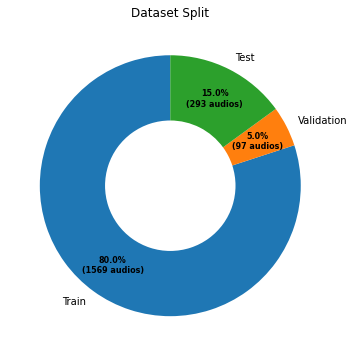

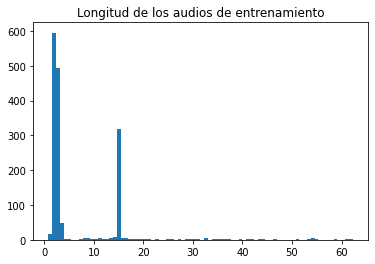

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

data_sizes = [len(d) for d in [dataset_train, dataset_val, dataset_test]] 
number_of_files = np.sum(data_sizes)
data_labels = ['Train', 'Validation', 'Test']

def func(pct, total):
    absolute = int(pct/100.*total)
    return "{:.1f}%\n({:d} audios)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data_sizes, labels=data_labels,
                           autopct=lambda pct: func(pct, number_of_files),
                           wedgeprops=dict(width=0.5),
                           pctdistance=.75,
                           startangle=90,
                           textprops=dict(color="k"))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Dataset Split", color='k')
plt.show()

audio_lengths = [len(a) / samplerate for a in dataset_train.get_sounds()]

plt.hist(audio_lengths, bins=80)
plt.title("Longitud de los audios de entrenamiento")
plt.show()

In [ ]:
last_try_path = 'Drive/My Drive/Reverb Dataset/Cache/last_exec.pickle'
try_info_path = 'Drive/My Drive/Reverb Dataset/Cache/try_{}.pickle'

load_stats = True
create_new_stats = False
load_stat_number = 23

if load_stats:
    if create_new_stats:
        if os.path.isfile(last_try_path):
            try_n = th.load(last_try_path) + 1
            th.save(try_n, last_try_path)
            print(f"Created try {try_n}")
        else:
            try_n = 0
            th.save(try_n, last_try_path)
            print("Creating first try...")

        current_epoch = 0
        epoch_losses = []
        bacth_losses = []
        val_epoch_losses = []

    else:
        try_n = load_stat_number
        stats = th.load(try_info_path.format(try_n))
        val_epoch_losses = stats['val_epoch']
        epoch_losses = stats['epoch_losses']
        bacth_losses = stats['bacth_losses']
        current_epoch = len(epoch_losses)

    print(f"Loaded try nº{try_n}")

Loaded try nº23


In [ ]:
!pip install -U --no-deps torchaudio

     |████████████████████████████████| 3.2MB 4.6MB/s 


In [ ]:
# https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
from torch.nn.modules.loss import *
from skimage.metrics import structural_similarity as ssim
from torchaudio.functional import *
from torchaudio.transforms import Spectrogram, MelSpectrogram, MelScale

class Sound_Loss():

    def __init__(self, mels=128, f_min=0, f_max=None, pad = 0, win_length = 400, window = th.hann_window,
                 nfft = 400, hop_length = 200, power = 2, normalized = False,
                 l1_perc = 0):
        self.pad = pad
        self.window = window(win_length).cuda()
        self.win_length = win_length 
        self.nfft = nfft
        self.hop_length = hop_length
        self.power = power
        self.normalized = normalized
        self.l1_perc = l1_perc
        self.f_max = f_max if f_max is not None else float(samplerate // 2)
        self.f_min = f_min
        self.n_mels = mels

    def _spectrogram(self, signal):
        spec = spectrogram(signal, pad=self.pad, window=self.window,
                           n_fft=self.nfft, hop_length=self.hop_length,
                           win_length=self.win_length, power=self.power,
                           normalized=self.normalized)

        mel_spec = self.mel_scale(spec)

        return mel_spec

    def pre_emphasis(self, signal, pre_emphasis = 0.97):
        return numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    def mel_scale(self, spec):
        shape = spec.size()
        spec = spec.view(-1, shape[-2], shape[-1])

        
        fb = create_fb_matrix(spec.size(1), self.f_min, self.f_max, self.n_mels, samplerate)
        mel_specgram = th.matmul(spec.transpose(1, 2), fb.cuda()).transpose(1, 2)

        # unpack batch
        mel_specgram = mel_specgram.view(shape[:-2] + mel_specgram.shape[-2:])

        return mel_specgram


    def __call__(self, input_m, target, debug=False):
        input_s = input_m.flatten()
        target_s = target.flatten()
        spect1 = self._spectrogram(input_s)
        spect2 = self._spectrogram(target_s)

        original_log = th.log10(th.pow(spect1, 2) + .1)
        target_log = th.log10(th.pow(spect2, 2) + .1)

        original_target_squared = th.pow(original_log - target_log, 2)
        target_lsd = th.mean(th.sqrt(th.mean(original_target_squared, axis=0) + 1e-8))

        mse = th.mean(th.abs((input_s - target_s)))

        if debug:
            print('original_log', original_log)
            print('target_log', target_log)
            print('original_target_squared', original_target_squared)
            print('target_lsd', target_lsd)

            plt.matshow(spect1.detach().cpu().numpy())
            plt.show()

            plt.matshow(spect2.detach().cpu().numpy())
            plt.show()

            plt.matshow(original_log.detach().cpu().numpy())
            plt.show()

            plt.matshow(target_log.detach().cpu().numpy())
            plt.show()

            plt.matshow(original_target_squared.detach().cpu().numpy())
            plt.show()

            plt.plot(th.sqrt(th.mean(original_target_squared, axis=0)).detach().cpu().numpy())
            plt.show()

            plt.plot(th.mean(original_target_squared, axis=0).detach().cpu().numpy())
            plt.show()

            print('sqrt', th.mean(th.sqrt(th.mean(original_target_squared, axis=0))),
                  '\nsin', th.mean(original_target_squared))


        return (1 - self.l1_perc) * target_lsd + self.l1_perc * mse

frame_size = 0.015
frame_stride = 0.01
frame_length, frame_step = int(frame_size * samplerate), int(frame_stride * samplerate) 

# print(frame_length, frame_step)
default_f_max = 2 * (samplerate / 2)//3
criterion = Sound_Loss(normalized=True, nfft=1024,
                         win_length=frame_length, hop_length=frame_step,
                         mels=128)

streams = dataset_val[0]
streams = streams.to(device)

x = streams[np.newaxis,:,1]
y = streams[np.newaxis,:,0]

if False:
    estimates = model(x)[0]
    estimate_size = estimates.size()[2]
    sources = center_trim(y, estimates)
    val_loss = criterion(estimates, sources, debug=True)
else:
    val_loss = criterion(x, y, debug=True)

print('\n\n\n--------\n', val_loss)

ModuleNotFoundError: ignored

In [ ]:
# %%time
from IPython.display import clear_output

from train import train_model
from torch import autograd, nn

from fractions import Fraction

from tqdm import tqdm_notebook
import time
import math

# criterion = nn.L1Loss()
criterion = Sound_Loss(normalized=False, nfft=1024,
                         win_length=frame_length, hop_length=frame_step,
                         mels=128, l1_perc=0.4)
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
batch_size = 4
workers = 4

samples = model.valid_length(args_samples)
data_stride = 44100
duration = samples + data_stride

dataset_train.set_duration(samples)

for epoch in range(10):

    loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)

    tq = tqdm.tqdm(loader,
                    ncols=90,
                    position=0,
                    desc=f"[{current_epoch:03d}] train",
                    leave=True,
                    file=sys.stdout,
                    unit=" batch")
    

    total_loss = 0
    current_loss = 0

    model.train()

    for idx, streams in enumerate(tq):

        streams = streams.to(device)

        x = streams[:,:,1]
        y = streams[:,:,0]

        estimates = model(x)

        estimate_size = estimates.size()[3]
        current_bacth_size = estimates.size()[0]

        sources = center_trim(y, estimates.view(current_bacth_size,1,estimate_size))

        loss = criterion(estimates, sources)
        
        loss_item = loss.item()
        total_loss += loss_item
        current_loss = total_loss / (1 + idx)
        tq.set_postfix(loss=f"{current_loss:.4f}")

        if math.isnan(loss_item):
            print('\nY:\n', y)
            print('\nX:\n', x)
            criterion(estimates, sources, debug=True)

            print('Lasts indexes', dataset_train.index_history[-10:])
            print('Lasts globa indexes', global_index_history[-10:])

            print('\nY:\n')
            for y_ in y:
                plt.plot(y_.detach().cpu().numpy().flatten())
                plt.show()

            print('\nX:\n')
            for y_ in y:
                plt.plot(y_.detach().cpu().numpy().flatten())
                plt.show()
            break
        else:
            # with autograd.detect_anomaly():
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            bacth_losses.append(loss_item)

        # free some space before next round
        del streams, estimates, loss, sources

    epoch_losses.append(current_loss)

    model.eval()

    val_loss = 0
    val_current_loss = 0

    indexes = range(len(dataset_val))
    tq = tqdm.tqdm(indexes,
                ncols=90,
                position=0,
                desc=f"[{current_epoch:03d}] valid",
                leave=True,
                file=sys.stdout,
                unit=" track")
    current_val_loss = 0

    for index in tq:

        streams = dataset_val[index]
        streams = streams.to(device)

        x = streams[np.newaxis,:,1]
        y = streams[np.newaxis,:,0]

        estimates = model(x)[0]

        estimate_size = estimates.size()[2]

        sources = center_trim(y, estimates)
        val_loss = criterion(estimates, sources)
        val_current_loss += val_loss.item() / len(indexes)

        tq.set_postfix(loss=f"{val_current_loss:.4f}")

        del estimates, streams, sources


    val_epoch_losses.append(val_current_loss)

    del loader, tq
    th.cuda.empty_cache()

    current_epoch += 1
    time.sleep(.2)

    if math.isnan(val_current_loss) or math.isnan(current_loss):
        print("Nan loss!! Escaping...")
        break

    th.save({
        'val_epoch': val_epoch_losses,
        'bacth_losses': bacth_losses,
        'epoch_losses': epoch_losses,
        'batch_size': batch_size,
        'args_samples': args_samples,
        'model': repr(model)
    }, try_info_path.format(try_n))
    th.save(model.state_dict(), f'Drive/My Drive/Reverb Dataset/Cache/model{try_n}.pth')

[069] valid: 100%|███████████████████████| 98/98 [00:22<00:00,  4.45 track/s, loss=0.5048]


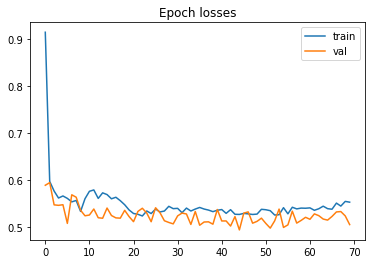

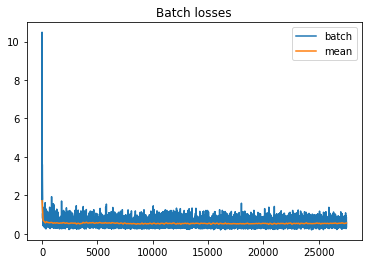

In [ ]:
# # try_n = 11
stats = th.load(try_info_path.format(try_n))
val_epoch_losses = stats['val_epoch']
epoch_losses = stats['epoch_losses']
bacth_losses = stats['bacth_losses']

plt.plot(epoch_losses)
plt.plot(val_epoch_losses)
plt.legend(['train', 'val'], loc='best')
plt.title("Epoch losses")
plt.show()

batch_sample = 100
batch_mean_size = len(bacth_losses) / batch_sample
batch_means = [n.mean() for n in np.array_split(np.array(bacth_losses), batch_mean_size)]
plt.plot(bacth_losses)
plt.plot(np.linspace(0, batch_mean_size * batch_sample, len(batch_means)),
         batch_means)

plt.legend(['batch', 'mean'], loc='best')
plt.title("Batch losses")
plt.show()


plt.show()

In [ ]:
import IPython.display as ipd

# 35 arp
# 25 xd

# gen_sound = dataset_val[0]
gen_sound = dataset_test[287]
# gen_sound = dataset_train[12]
test0 = gen_sound[0, 0]
test1 = gen_sound[0, 1]

In [ ]:
# original
ipd.Audio(test0, rate=samplerate)

In [ ]:
# original with reverb
ipd.Audio(test1, rate=samplerate)

In [ ]:
# dereverberation
estimates1 = model(test1.reshape((1,1,len(test1))).cuda()).cpu().detach().numpy().flatten()
ipd.Audio(estimates1, rate=samplerate)

In [ ]:
# just input the no reverb audio
estimates2 = model(test0.reshape((1,1,441000)).cuda()).cpu().detach().numpy().flatten()
ipd.Audio(estimates2, rate=samplerate)

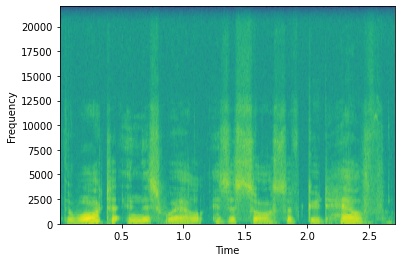

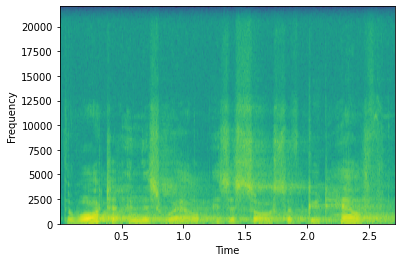

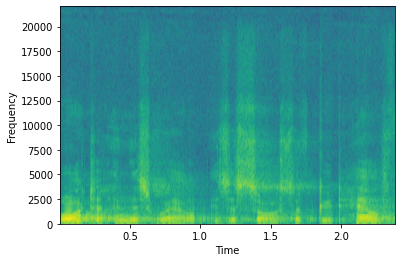

In [ ]:
plt.specgram(test0,Fs=samplerate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show();

plt.specgram(test1,Fs=samplerate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show();

plt.specgram(estimates1,Fs=samplerate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show();

In [ ]:
# th.save({
#     'val_epoch': val_epoch_losses,
#     'bacth_losses': bacth_losses,
#     'epoch_losses': epoch_losses,
#     'batch_size': batch_size,
#     'args_samples': args_samples,
#     'model': repr(model)
# }, try_info_path.format(try_n))
# th.save(model.state_dict(), f'Drive/My Drive/Reverb Dataset/Cache/model{try_n}.pth')

In [ ]:
model.load_state_dict(th.load('Drive/My Drive/Reverb Dataset/Cache/model19.pth'))

<All keys matched successfully>

In [ ]:
dataset_test.set_reverb_param({'reverberance':100})

In [ ]:
reverb_1 = {
    'reverberance':10,
    'room_scale': 10,
    'pre_delay': 5,
    'hf_damping': 0
}


In [ ]:
np.linspace(0, 30, 15)

array([ 0.        ,  2.14285714,  4.28571429,  6.42857143,  8.57142857,
       10.71428571, 12.85714286, 15.        , 17.14285714, 19.28571429,
       21.42857143, 23.57142857, 25.71428571, 27.85714286, 30.        ])

In [ ]:
sound_loss = Sound_Loss(normalized=False, nfft=1024,
                         win_length=frame_length, hop_length=frame_step,
                         mels=128, l1_perc=0.4)

dataset_test.use_augmentation(False)

metrics = []

x_axis = np.linspace(0, 30, 15)

for n in x_axis:

    results = []
    ground_truths = []
    inputs = []

    dataset_test.set_reverb_param({'pre_delay':n})

    for d in dataset_test:
        input_tensor = d[:,1, np.newaxis,:].cuda()
        ground_truth = d[:,0, np.newaxis,:]

        # random_length = random.randint(samplerate, ground_truth.size(-1))

        # input_tensor = input_tensor[:,:,:random_length]
        # ground_truth = ground_truth[:,:,:random_length]

        dereverbed = model(input_tensor)

        ground_truth = center_trim(ground_truth, dereverbed.view(1, 1, dereverbed.size()[3]))
        results.append(dereverbed.cpu().detach())
        ground_truths.append(ground_truth)
        inputs.append(input_tensor.cpu().detach().numpy().flatten())

    soundlosses = []
    for data, dereverbs in zip(ground_truths, results):
        ground_truth = data[:,0,:].flatten()
        generated = dereverbs.flatten()
        
        soundlosses.append(sound_loss(ground_truth.cuda(), generated.cuda()).item())

    metrics.append(np.array(soundlosses))
    print(n)

metrics = np.array(metrics)

0.0
2.142857142857143
4.285714285714286
6.428571428571429
8.571428571428571
10.714285714285714
12.857142857142858
15.0
17.142857142857142
19.285714285714285
21.428571428571427
23.57142857142857
25.714285714285715
27.857142857142858
30.0


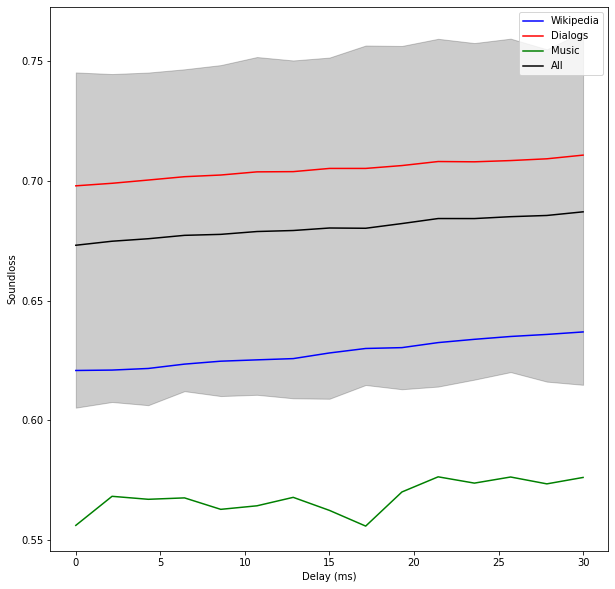

In [ ]:
mean_wiki = []
mean_dialog = []
mean_music = []
mean_all = []

q20_wiki = []
q80_wiki = []

q20_dialog = []
q80_dialog = []

q20_music = []
q80_music = []

q20_all = []
q80_all = []


up_q = 0.80
down_q = 0.20

for losses in metrics:

    _losses = losses[dataset_types_2 == 'wikipedia']
    mean_wiki.append(np.mean(_losses) )
    q20_wiki.append(np.quantile(_losses, up_q)) 
    q80_wiki.append(np.quantile(_losses, down_q)) 

    _losses = losses[dataset_types_2 == 'dialogs']
    mean_dialog.append(np.mean(_losses) )
    q20_dialog.append(np.quantile(_losses, up_q) )
    q80_dialog.append(np.quantile(_losses, down_q) )

    _losses = losses[dataset_types_2 == 'music']
    mean_music.append(np.mean(_losses)) 
    q20_music.append(np.quantile(_losses, up_q)) 
    q80_music.append(np.quantile(_losses, down_q)) 

    mean_all.append(np.mean(losses)) 
    q20_all.append(np.quantile(losses, up_q)) 
    q80_all.append(np.quantile(losses, down_q)) 


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, mean_wiki, 'b-')
# ax.fill_between(np.arange(0, 101, 10), q20_wiki, q80_wiki, alpha=0.2, color='b')

ax.plot(x_axis, mean_dialog, 'r-')
# ax.fill_between(np.arange(0, 101, 10), q20_dialog, q80_dialog, alpha=0.2, color='r')

ax.plot(x_axis, mean_music, 'g-')
# ax.fill_between(np.arange(0, 101, 10), q20_music, q80_music, alpha=0.2, color='g')

ax.plot(x_axis, mean_all, 'k-')
ax.fill_between(x_axis, q20_all, q80_all, alpha=0.2, color='k')

plt.xlabel('Delay (ms)')
plt.ylabel('Soundloss')

plt.legend(['Wikipedia', 'Dialogs', 'Music', 'All'], loc='best')

plt.show()

In [ ]:
room_losses = metrics

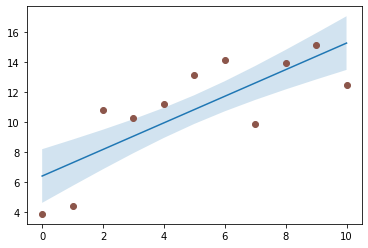

In [ ]:
N = 21
x = np.linspace(0, 10, 11)
y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

# fit a linear curve an estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(x, y, 'o', color='tab:brown')

In [ ]:
from skimage.metrics import structural_similarity as ssim
from torch import nn

mses = []
l1s = []
soundlosses = []
lsds = []
ssim_losses = []

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
lsd_loss = Sound_Loss(normalized=False, nfft=1024,
                         win_length=frame_length, hop_length=frame_step,
                         mels=128, l1_perc=0)

for data, dereverbs in zip(ground_truths, results):
    ground_truth = data[:,0,:].flatten()
    generated = dereverbs.flatten()
    
    l1s.append(l1_loss(ground_truth, generated).item())
    mses.append(mse_loss(ground_truth, generated).item())
    lsds.append(lsd_loss(ground_truth.cuda(), generated.cuda()).item())
    soundlosses.append( 0.6 * lsds[-1] + 0.4 * mses[-1])
    ssim_losses.append(
        ssim(ground_truth.cpu().detach().numpy().flatten(),
             generated.cpu().detach().numpy().flatten())
    )

In [ ]:
import pandas as pd
df = pd.DataFrame({'l1': l1s, 'mse':mses, 'lsd':lsds, 'soundloss': soundlosses, 'ssim':ssim_losses})
df.describe()

l1         mse         lsd   soundloss        ssim
count  294.000000  294.000000  294.000000  294.000000  294.000000
mean     0.223976    0.122252    0.988783    0.642171    0.432590
std      0.038481    0.043753    0.148358    0.095656    0.068853
min      0.133845    0.049974    0.403183    0.269501    0.127984
25%      0.197845    0.094688    0.901846    0.585648    0.388432
50%      0.219325    0.113088    0.992255    0.640838    0.431673
75%      0.240564    0.139883    1.084041    0.702272    0.471295
max      0.457635    0.351255    1.430595    0.969999    0.720065

In [ ]:
index_sorts = df.soundloss.argsort()

In [ ]:
index = index_sorts.values[-4]
ipd.Audio(inputs[index], rate=samplerate)

In [ ]:
ipd.Audio(results[index].flatten(), rate=samplerate)

In [ ]:
import re

dataset_types = []

for p in dataset_test.paths:
    
    from_wikipedia = re.search('Drive/My Drive/Reverb Dataset/d_wikipedia/input/.*\.wav', p)
    if from_wikipedia:
        dataset_types.append('wikipedia')

    dialogs = re.search('Drive/My Drive/Reverb Dataset/dv_./input/.*\.wav', p)
    if dialogs:
        dataset_types.append('dialogs')

    music = re.search('Drive/My Drive/Reverb Dataset/d_./input/.*\.wav', p)
    if music:
        dataset_types.append('music')

pd.series(dataset_types)

In [ ]:
sounds_lengths = [len(s)/samplerate for s in inputs]

In [ ]:
dataset_types_2 = np.array(dataset_types)

In [ ]:
sounds_lengths = np.array(sounds_lengths)

0.07382780592016688
0.07518039648439073
0.17569688656233615


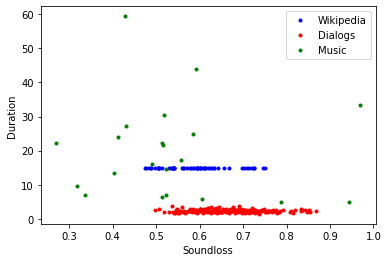

In [ ]:
lenghts = sounds_lengths[dataset_types_2 == 'wikipedia']
losses = df.soundloss[dataset_types_2 == 'wikipedia'].values
print(np.std(losses))
plt.plot(losses, lenghts, 'b.')

lenghts = sounds_lengths[dataset_types_2 == 'dialogs']
losses = df.soundloss[dataset_types_2 == 'dialogs'].values
print(np.std(losses))
plt.plot(losses, lenghts, 'r.')

lenghts = sounds_lengths[dataset_types_2 == 'music']
losses = df.soundloss[dataset_types_2 == 'music'].values
print(np.std(losses))
plt.plot(losses, lenghts, 'g.')

plt.xlabel('Soundloss')
plt.ylabel('Duration')

plt.legend(['Wikipedia', 'Dialogs', 'Music'], loc='best')
plt.show()